In [79]:
import gurobipy as gb
from gurobipy import GRB

Let's do a simple model with 6 orders 2 plants and 3 ports. 

We want to decide for each order where to produce and where to send from.

In [80]:
order_items = [1,2,1,1,3,3,3,2]
item_production_costs_for_plants = [[10,12,8], [9,13,5]]
shipment_costs_for_ports = [2, 3, 5]
plant_order_limits = [6, 6]
plant_port_connection = [[2], [0,1,2]]

number_of_orders = len(order_items)
number_of_plants = len(item_production_costs_for_plants)
number_of_ports = len(shipment_costs_for_ports)


In [81]:
order_allocation_model = gb.Model('order_allocation_model')

plant_allocation = order_allocation_model.addVars(number_of_orders, number_of_plants, vtype=GRB.BINARY, name='plant_allocation')
port_allocation = order_allocation_model.addVars(number_of_orders, number_of_ports, vtype=GRB.BINARY, name='port_allocation')

In [82]:
order_allocation_model.setObjective(gb.quicksum(item_production_costs_for_plants[index_plant][order_items[index_order] - 1] * 
                                                plant_allocation[index_order, index_plant] 
                                                for index_order in range(number_of_orders) 
                                                for index_plant in range(number_of_plants)) 
                                    +
                                    gb.quicksum(shipment_costs_for_ports[index_port] * port_allocation[index_order, index_port]
                                                for index_order in range(number_of_orders)
                                                for index_port in range(number_of_ports)),
                                    GRB.MINIMIZE
                                    )

In [83]:
for index_order in range(number_of_orders):
    order_allocation_model.addConstr(gb.quicksum(plant_allocation[index_order, index_plant] for index_plant in range(number_of_plants))==1, name=f'order_{index_order}_to_ONE_plant')

for index_order in range(number_of_orders):
    order_allocation_model.addConstr(gb.quicksum(port_allocation[index_order, index_port] for index_port in range(number_of_ports))==1, name=f'order_{index_order}_to_ONE_port')
    
for index_plants in range(number_of_plants):
    order_allocation_model.addConstr(gb.quicksum(plant_allocation[index_orders, index_plants] for index_orders in range(number_of_orders)) <= plant_order_limits[index_plants], name=f'plant_{index_plants}_order_limit')
    

for index_order in range(number_of_orders):
    for index_plant in range(number_of_plants):
        for index_port in range(number_of_ports):
            if index_port not in plant_port_connection[index_plant]:
                order_allocation_model.addConstr(plant_allocation[index_order, index_plant] + port_allocation[index_order, index_port] <= 1, name=f'order_{index_order}_plant_{index_plant}_not_conn_to_port_{index_port}')

for index_plant in range(number_of_plants):
    order_allocation_model.addConstr(gb.quicksum(plant_allocation[index_order, index_plant] for index_order in range(number_of_orders)) <= plant_order_limits[index_plant], name=f'order_limit_plant_{index_plant}')

In [84]:
order_allocation_model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1250U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 36 rows, 40 columns and 104 nonzeros
Model fingerprint: 0xe4fb82f8
Variable types: 0 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 116.0000000
Presolve removed 36 rows and 40 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 88 116 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.800000000000e+01, best bound 8.800000000000e+01, gap 0.0000%


In [85]:
if order_allocation_model.status == GRB.OPTIMAL:
    allocation = []  # List to store the allocation of orders

    # Loop through each order
    for i in range(number_of_orders):
        # Check each plant for the current order
        assigned_plant = None
        for j in range(number_of_plants):
            if plant_allocation[i, j].x > 0.5:  # If order i is assigned to plant j
                assigned_plant = j
                break
        
        # Check each port for the current order
        assigned_port = None
        for k in range(number_of_ports):
            if port_allocation[i, k].x > 0.5:  # If order i is shipped through port k
                assigned_port = k
                break
        
        # Append the allocation as a tuple (order, plant, port)
        if assigned_plant is not None and assigned_port is not None:
            allocation.append((i, assigned_plant, assigned_port))

    # Print the allocation results
    print("Order allocations (order, plant, port):", allocation)
else:
    print("No optimal solution found. Status code:", order_allocation_model.status)

Order allocations (order, plant, port): [(0, 1, 0), (1, 0, 2), (2, 1, 0), (3, 1, 0), (4, 1, 0), (5, 1, 0), (6, 1, 0), (7, 0, 2)]


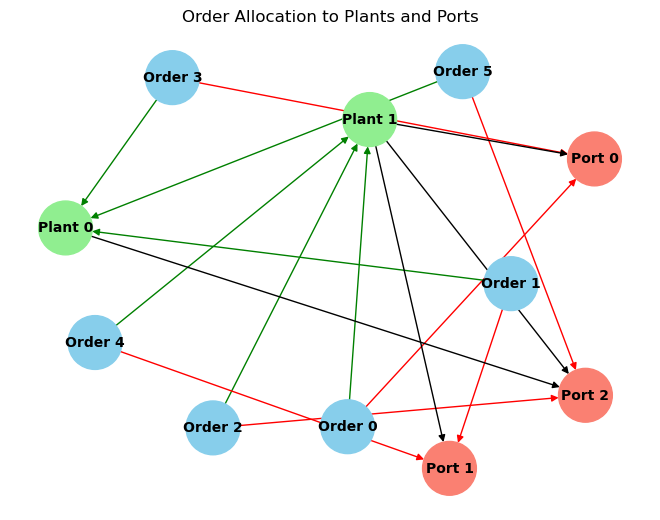

In [86]:
import matplotlib.pyplot as plt
import networkx as nx

# Sample allocation output, replace this with actual allocation from the optimization
allocation = [(0, 1, 0), (1, 0, 1), (2, 1, 2), (3, 0, 0), (4, 1, 1), (5, 0, 2)]

# Create a directed graph
G = nx.DiGraph()

# Add nodes for orders, plants, and ports with different colors
order_nodes = [f"Order {i}" for i, _, _ in allocation]
plant_nodes = [f"Plant {j}" for _, j, _ in allocation]
port_nodes = [f"Port {k}" for _, _, k in allocation]

# Use unique sets for plants and ports since they can be reused
plants = list(set(plant_nodes))
ports = list(set(port_nodes))

G.add_nodes_from(order_nodes, color='skyblue', node_type='Order')
G.add_nodes_from(plants, color='lightgreen', node_type='Plant')
G.add_nodes_from(ports, color='salmon', node_type='Port')

# Add edges based on the allocation, with labels for clarity
edges = []
for order, plant, port in allocation:
    order_node = f"Order {order}"
    plant_node = f"Plant {plant}"
    port_node = f"Port {port}"
    G.add_edge(order_node, plant_node, color='green')
    # G.add_edge(plant_node, port_node, color='red')
    G.add_edge(order_node, port_node, color='red')
    
for plant in range(number_of_plants):
    for port in plant_port_connection[plant]:
        plant_node = f'Plant {plant}'
        port_node = f'Port {port}'
        G.add_edge(plant_node, port_node, color='black')

# Draw the graph
colors = [G.nodes[node]['color'] for node in G.nodes]
edge_colors = [G[u][v]['color'] for u, v in G.edges]
pos = nx.spring_layout(G, k=2, iterations=50, seed=2)  # Layout for a clear presentation

# Plot nodes with labels and custom colors
nx.draw(G, pos, with_labels=True, node_color=colors, edge_color=edge_colors, node_size=1500, font_size=10, font_weight='bold')
plt.title("Order Allocation to Plants and Ports")
plt.show()


In [87]:
port_allocation

{(0, 0): <gurobi.Var port_allocation[0,0] (value 1.0)>,
 (0, 1): <gurobi.Var port_allocation[0,1] (value 0.0)>,
 (0, 2): <gurobi.Var port_allocation[0,2] (value 0.0)>,
 (1, 0): <gurobi.Var port_allocation[1,0] (value 0.0)>,
 (1, 1): <gurobi.Var port_allocation[1,1] (value 0.0)>,
 (1, 2): <gurobi.Var port_allocation[1,2] (value 1.0)>,
 (2, 0): <gurobi.Var port_allocation[2,0] (value 1.0)>,
 (2, 1): <gurobi.Var port_allocation[2,1] (value 0.0)>,
 (2, 2): <gurobi.Var port_allocation[2,2] (value 0.0)>,
 (3, 0): <gurobi.Var port_allocation[3,0] (value 1.0)>,
 (3, 1): <gurobi.Var port_allocation[3,1] (value 0.0)>,
 (3, 2): <gurobi.Var port_allocation[3,2] (value 0.0)>,
 (4, 0): <gurobi.Var port_allocation[4,0] (value 1.0)>,
 (4, 1): <gurobi.Var port_allocation[4,1] (value 0.0)>,
 (4, 2): <gurobi.Var port_allocation[4,2] (value 0.0)>,
 (5, 0): <gurobi.Var port_allocation[5,0] (value 1.0)>,
 (5, 1): <gurobi.Var port_allocation[5,1] (value 0.0)>,
 (5, 2): <gurobi.Var port_allocation[5,2] (value

In [89]:
order_allocation_model.computeIIS()
for constraint in order_allocation_model.getConstrs():
    if constraint.IISConstr:
        print(f'Constraint {constraint.ConstrName} is in the IIS')

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1250U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

IIS computation: initial model status unknown, solving to determine model status
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
IIS runtime: 0.01 seconds (0.00 work units)


GurobiError: Cannot compute IIS on a feasible model